# Cryptolytic Arbitrage Modeling

This notebook contains the code to create the arbitrage models used in the Cryptolytic project. You can find more information on data processing in this [notebook](https://github.com/Cryptolytic-app/cryptolyticapp/blob/master/modeling/1_arbitrage_data_processing.ipynb) and model evaluation in this [notebook](https://github.com/Cryptolytic-app/cryptolyticapp/blob/master/modeling/3_arbitrage_model_evaluation.ipynb).

<!-- <img src="https://github.com/Cryptolytic-app/cryptolyticapp/blob/master/assets/cryptolytic_thumbnail.png?raw=true"
     alt=" "
     align= "center"
     style="width: 500px;" /> -->
     
#### What is arbitrage?
Arbitrage occurs when there is a price difference between the same asset in two different markets. So with crypto, it’s possible to have the same coin priced differently on separate exchanges. For example with bitcoin, you might have bitcoin priced at $8,000 on one exchange, and at the same time that bitcoin can be priced at $8,100 on another exchange. You can buy the bitcoin on the first exchange for $8,000, send it to the other exchange, and sell it for $8,100. Now you’ve made $100 in profit and you can repeat this process as long as that arbitrage opportunity lasts.

#### Background on arbitrage models
There are many different combinations of arbitrage that could be occuring at any given moment among all the cryptocurrency exchanges. Our goal was to capture as many of these as possible in order to create an API that provides predictions for any arbitrage opportunities that will occur in the next 10 minutes. This API could then serve as the backend for a web application that displays the predictions in a more user-friendly format.

The arbitrage models in this notebook predict arbitrage 10 min before it happens, lasting for at least 30 mins. It's important that the arbitrage window lasts long enough because it takes time to move coins from one exchange to the other in order to successfully complete the arbitrage trades. The datasets used for modeling are generated by getting all of the combinations of 2 exchanges that support the same trading pair, engineering technical analysis features, merging that data on 'closing_time', engineering more features, and creating a target that signals an arbitrage opportunity. Arbitrage signals predicted by the models have a direction indicating which direction the arbitrage occurs in.

#### What kind of machine learning problem is this?
Arbitrage can occur in two directions, one from the the first exchange to the second and vice versa, so there are 3 possible classes for a target which makes this a multiclass classification problem.

The targets are:
- 1: arbitrage from exchange 1 to exchange 2 starting 10 mins after prediction time, lasting 30 mins
- 0: no arbitrage 10 mins after prediction time
- -1: arbitrage from exchange 2 to exchnage 1 starting 10 mins after prediction time, lasting 30 mins

Random Forest Classifiers were used for modeling since they would work well with multiclass targets and imbalanced time series data.

#### What models were created?
After looking at the class distributions among the datasets of the 95 possible combinations, there were 15 options that contained enough of each target class to generate useful models. Instead of creating only one model to predict arbitrage 10 minutes out for any arbitrage combination, we chose to create individual models so that the model could better learn the nuances of that particular cryptocurrency pair:

- bitfinex_cbpro_etc_usd
- cbpro_bitfinex_ltc_usd
- hitbtc_cbpro_eth_usdc
- cbpro_bitfinex_eth_usd
- bitfinex_hitbtc_bch_usdt
- gemini_bitfinex_bch_btc
- gemini_hitbtc_bch_btc
- cbpro_gemini_bch_btc
- kraken_gemini_bch_btc
- bitfinex_cbpro_btc_usd
- gemini_kraken_ltc_btc
- bitfinex_hitbtc_ltc_usdt
- gemini_bitfinex_ltc_btc
- gemini_hitbtc_ltc_btc
- gemini_cbpro_ltc_btc

#### Train/Test Split
We did a 70/30 train/test split on the data that fell anywhere in the range from Jun 2015 - Oct 2019. There was a 2 week gap left between the train and test sets to prevent data leakage. Cross validation was not suitable in this case because arbitrage opportunites were already scarce and doing a 5-fold cross validation on time series data only limited the training data for some already small datasets.

#### Baseline
As a baseline, we created 15 Logistic Regression models with the lbfgs solver, one for each arbitrage combination. For training, we used all 139 features that were created after feature engineering.

#### Modeling
After running baseline models, we trained 15 Random Forest models with the default parameters, selected the most important features from that model, and used those features in hyperparameter tuning. Feature importance was determined using sklearn's `feature_importances_` method

The top 20 features for one of the best models cbpro_bitfinex_ltc_usd were:

<img src="https://github.com/Cryptolytic-app/cryptolyticapp/blob/master/modeling/assets/feat_imp.png?raw=true"
     alt=" "
     align= "center"
     style="width: 600px;" />

The 100 most important features were then used for tuning the `max_depth`, `max_features`, and `n_estimators` parameters:
 - max_depth: [17, 19, 21, 25, 30, 40]
 - max_features: [auto, 50, 55, 60, 65, 70, 75]
 - n_estimators: [100, 150]


#### Model Evaluation Criteria
 - Mean Percent Profit *
 - False Positive Rate (FPR)
 - Precison
 - Recall
 - F1 Score
 - Status

\* The profit calculation incorporates fees like in the real world. We used mean percent profit as the profitability metric which represented the average percent profit per arbitrage trade if one were to act on all trades predicted by the model in the testing period, whether those predictions were correct or not.

#### Results
Model performance is discussed in the evaluation [notebook](https://github.com/Cryptolytic-app/cryptolytic/blob/master/modeling/1_arbitrage_model_evaluation.ipynb)

#### Running this notebook 
Runtime approx. 4 hours

Data exported: less than 1 mb

- 2 txt files in `data/`
- 1 csv file in `data/`

Note:

It is highly recommended to run this on sagemaker (ml.m4.16xlarge instance). There are 15 total options for models, and between baseline logistic regression, random forest, and random forest with hyperparameter tuning, 1290 models will be trained. 

#### Directory Structure
```
├── cryptolytic/                        <-- Root directory   
│   ├── modeling/                       <-- Directory for modeling work
│   │      │
│   │      ├──assets/                   <-- Directory with png assets used in notebooks
│   │      │
│   │      ├──data/                     <-- Directory containing all data for project
│   │      │   ├─ arb_data/             <-- Directory for train data after merging + FE pt.2
│   │      │   │   └── *.csv
│   │      │   │
│   │      │   ├─ arb_preds_test_data/  <-- Directory for test data w/ predictions
│   │      │   │   └── *.csv 
│   │      │   │
│   │      │   ├─ arb_top_data/         <-- Directory for data from the best models
│   │      │   │   └── *.csv
│   │      │   │
│   │      │   ├─ raw_data/             <-- Directory for raw training data
│   │      │   │   └── *.csv
│   │      │   │
│   │      │   ├─ ta_data/              <-- Directory for csv files after FE pt.1 
│   │      │   │   └── *.csv
│   │      │   │
│   │      │   ├─ raw_zip_data/         <-- Directory containing zip files of raw data
│   │      │   │   └── *.zip
│   │      │   │
│   │      │   ├─ all_features.txt      <-- All features used in baseline models
│   │      │   │
│   │      │   ├─ top_features.txt      <-- Most important features for models
│   │      │   │
│   │      │   ├─ model_perf.csv        <-- Data from training baseline models and tuning
│   │      │   │
│   │      │   ├─ top_model_perf.csv    <-- Data from retraining and exporting best models
│   │      │
│   │      ├── models/                  <-- Directory for all pickle models
│   │      │      └── *.pkl
│   │      │
│   │      ├─ 1_arbitrage_data_processing.ipynb  <-- NB for data processing and creating csv
│   │      │
│   │      ├─ 2_arbitrage_modeling.ipynb         <-- NB for baseline models and tuning
│   │      │
│   │      ├─ 3_arbitrage_model_evaluation.ipynb <-- NB for model selection, eval, and viz
│   │      │
│   │      ├─ trade_recommender_models.ipynb     <-- NB for trade recommender models
│   │      │
│   │      ├─ environment.yml                    <-- Contains project dependencies
│   │      │
│   │      ├─ utils.py                           <-- All the functions used in modeling
│   │      │

```

## Imports

This project uses conda to manage environments.

In [1]:
# to update your conda env from a yml file from terminal
# conda env update --file modeling/environment.yml

# to export yml from terminal(will get errors if you run it like this, only work on same builds/OS)
# conda env export > modeling/environment.yml

# USE THIS METHOD - this will work with different builds/OS but still had few errors on packages, commented them out in yml file
# conda env export --no-builds > environment.yml

In [4]:
import glob
import os
import pickle
import json
import itertools
from zipfile import ZipFile
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_rows', 100000)
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

from ta import add_all_ta_features

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid

## Data

Open the [txt file](https://github.com/Cryptolytic-app/cryptolyticapp/blob/master/modeling/data/train_data_paths.txt) that contains all the arbitrage datasets that should be used for modeling.

In [5]:
with open ('data/train_data_paths.txt', 'rb') as fp:
    train_data_paths = pickle.load(fp)
print(len(train_data_paths))
train_data_paths

15


['data/arb_data/bitfinex_cbpro_etc_usd.csv',
 'data/arb_data/cbpro_bitfinex_ltc_usd.csv',
 'data/arb_data/hitbtc_cbpro_eth_usdc.csv',
 'data/arb_data/cbpro_bitfinex_eth_usd.csv',
 'data/arb_data/bitfinex_hitbtc_bch_usdt.csv',
 'data/arb_data/gemini_bitfinex_bch_btc.csv',
 'data/arb_data/gemini_hitbtc_bch_btc.csv',
 'data/arb_data/cbpro_gemini_bch_btc.csv',
 'data/arb_data/kraken_gemini_bch_btc.csv',
 'data/arb_data/bitfinex_cbpro_btc_usd.csv',
 'data/arb_data/gemini_kraken_ltc_btc.csv',
 'data/arb_data/bitfinex_hitbtc_ltc_usdt.csv',
 'data/arb_data/gemini_bitfinex_ltc_btc.csv',
 'data/arb_data/gemini_hitbtc_ltc_btc.csv',
 'data/arb_data/gemini_cbpro_ltc_btc.csv']

Each dataset looks like this and should have 141 columns.

In [8]:
df = pd.read_csv(train_data_paths[7], index_col=0)
print(df.shape)
df.head()

(12047, 141)


,open_exchange_1,high_exchange_1,low_exchange_1,close_exchange_1,base_volume_exchange_1,nan_ohlcv_exchange_1,volume_adi_exchange_1,volume_obv_exchange_1,volume_cmf_exchange_1,volume_fi_exchange_1,...,year,month,day,higher_closing_price,pct_higher,arbitrage_opportunity,window_length,arbitrage_opportunity_shift,window_length_shift,target
0,0.03096,0.03100,0.03096,0.03099,0.568059,0.0,-0.799772,-10166.832365,-0.215566,0.000005,...,2019,9,23,0,0.000000,0,10,0.0,45.0,0
1,0.03102,0.03104,0.03098,0.03098,2.168086,0.0,-1.884056,-10169.000451,-0.437834,0.000022,...,2019,9,23,2,0.032279,0,15,0.0,50.0,0
2,0.03097,0.03103,0.03097,0.03101,0.379977,0.0,-2.041427,-10168.620474,-0.392998,-0.000004,...,2019,9,23,1,0.064537,0,20,1.0,5.0,0
3,0.03098,0.03098,0.03098,0.03098,0.312936,0.0,0.126659,-10168.933410,-0.399682,-0.000000,...,2019,9,23,2,0.032279,0,25,1.0,10.0,0
4,0.03098,0.03099,0.03098,0.03099,1.390789,0.0,1.390789,-10167.542621,-0.299690,-0.000020,...,2019,9,23,0,0.000000,0,30,1.0,15.0,0


## Modeling Functions

#### Print Statements

In [9]:
line = '-------------'
sp = '      '

def print_model_name(name, i, train_data_paths):
    ''' Print Status on Model # '''
    print(
    '\n\n', line*8, '\n\n', 
    f'Model {i+1}/{len(train_data_paths)}: {name}', '\n', 
    line*8
    )

def print_model_params(i, params, pg_list): 
    ''' Print Status on Parameter Combo '''
    print(
        sp*2, line*5, '\n', 
        sp*2, f'Model {i+1}/{len(pg_list)}', '\n',  
        sp*2, f'params={params if params else None}', '\n', 
        sp*2, line*5
    )

#### Calculating Profit

In [10]:
# specifying arbitrage window length to target, in minutes
interval = 30

def get_higher_closing_price(df):
    """
    Returns the exchange with the higher closing price
    """
    # exchange 1 has higher closing price
    if (df['close_exchange_1'] - df['close_exchange_2']) > 0:
        return 1
    
    # exchange 2 has higher closing price
    elif (df['close_exchange_1'] - df['close_exchange_2']) < 0:
        return 2
    
    # closing prices are equivalent
    else:
        return 0

def get_close_shift(df, interval=interval):
    """
    Shifts the closing prices by the selected interval +
    10 mins.
    
    Returns a df with new features:
    - close_exchange_1_shift
    - close_exchange_2_shift
    """
    
    
    rows_to_shift = int(-1*(interval/5))
    
    df['close_exchange_1_shift'] = df['close_exchange_1'].shift(
        rows_to_shift - 2)
    
    df['close_exchange_2_shift'] = df['close_exchange_2'].shift(
        rows_to_shift - 2)
    
    return df

def get_profit(df):
    """
    Calculates the profit of an arbitrage trade.
    Returns df with new profit feature.
    """
    
    # if exchange 1 has the higher closing price
    if df['higher_closing_price'] == 1:
        
        # return how much money you would make if you bought 
        # on exchange 2, sold on exchange 1, and took account 
        # of 0.55% fees
        return (((df['close_exchange_1_shift'] / 
                 df['close_exchange_2'])-1)*100)-.55
    
    # if exchange 2 has the higher closing price
    elif df['higher_closing_price'] == 2:
        
        # return how much money you would make if you bought 
        # on exchange 1, sold on exchange 2, and took account 
        # of 0.55% fees
        return (((df['close_exchange_2_shift'] / 
                 df['close_exchange_1'])-1)*100)-.55
    
    # if the closing prices are the same
    else:
        return 0 # no arbitrage

def profit(X_test, y_preds):
    """ 
    Calculate median/mean percent profit and return it
    Using get_profit, get_close_shift, get_higher_closing_price functions
    """
    # creating dataframe from test set to calculate profitability
    test_with_preds = X_test.copy()

    # add column with higher closing price
    test_with_preds['higher_closing_price'] = test_with_preds.apply(
            get_higher_closing_price, axis=1)

    # add column with shifted closing price
    test_with_preds = get_close_shift(test_with_preds)

    # adding column with predictions
    test_with_preds['pred'] = y_preds

    # adding column with profitability of predictions
    test_with_preds['pct_profit'] = test_with_preds.apply(
            get_profit, axis=1).shift(-2)

    # filtering out rows where no arbitrage is predicted
    test_with_preds = test_with_preds[test_with_preds['pred'] != 0]

    # calculating mean profit where arbitrage predicted...
    pct_profit_mean = round(test_with_preds['pct_profit'].mean(), 2)

    # calculating median profit where arbitrage predicted...
    pct_profit_median = round(test_with_preds['pct_profit'].median(), 2)
    
    return pct_profit_mean, pct_profit_median

#### Parameters

In [11]:
def create_pg(param_grid):
    """
    Selects the correct parameters
    for each model
    """
    if not param_grid:
        pg_list = [param_grid]
    # checks if the params in param_grid are iterable
    # and if not, it turns them into iterables to be used 
    # with ParameterGrid()
    else:
        for key in param_grid:
            if isinstance(param_grid[key], list):         
                pg_list = list(ParameterGrid(param_grid))
            else:
                pg_list = [param_grid]
    return pg_list

#### Model Naming Conventions

In [12]:
def model_names(param_grid, params, csv_name, model_label):
    """
    Create unique model names
    """
    if param_grid:
        model_id = '_'.join([
            csv_name, 
            model_label,
            str(params['max_features']), 
            str(params['max_depth']), 
            str(params['n_estimators'])
        ])
    else:
        model_id = csv_name + '_' + model_label

    model_path = f'models/{model_id}.pkl'
    
    return model_id, model_path

#### Train/Test Split

In [7]:
def ttsplit(df, features, target):
    """
    Train/Test Split 80/20 
    2 week gap left between the train and test sets
    Returns X_train, X_test, y_train, y_test, test
    """
    
    ## tt split
    # remove 2 weeks from train datasets to create a  
    # two week gap between the data - prevents data leakage
    tt_split_row = round(len(df)*.82)
    tt_split_time = df['closing_time'][tt_split_row]
    cutoff_time = tt_split_time - dt.timedelta(days=14)

    # train and test subsets
    train = df[df['closing_time'] < cutoff_time]
    test = df[df['closing_time'] > tt_split_time]
    
    # X, y matrix
    X_train = train[features]
    X_test = test[features]
    y_train = train[target]
    y_test = test[target]
    
    print(X_train.shape, y_train.shape,target)
    # printing shapes to track progress
    print(sp*2, 'train and test shape: ', train.shape, test.shape)
    
    return X_train, X_test, y_train, y_test, test

#### Evaluation Metrics

In [8]:
def model_eval(X_test, y_test, y_preds, model_id, csv_name, 
               model_label, params):
    """
    Calculates model eval metrics
    
    Returns a dictionary with model evaluation metrics and model name
    """
    pct_prof_mean, pct_prof_median = profit(X_test, y_preds)
    print(sp*2,'percent profit mean:', pct_prof_mean)
    print(sp*2, 'percent profit median:', pct_prof_median, '\n\n')
    
    accuracy = accuracy_score(y_test, y_preds)
    
    # labels for confusion matrix
    unique_y_test = y_test.unique().tolist()
    unique_y_preds = list(set(y_preds))
    labels = list(set(unique_y_test + unique_y_preds))
    labels.sort()
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]

    # create confusion matrix and classification report
    conf_mat = pd.DataFrame(
        confusion_matrix(y_test, y_preds),
        columns=columns, index=index
    )
    class_report = classification_report(
        y_test, 
        y_preds, 
        digits=4, 
        output_dict=True
    )
    print(conf_mat, '\n')
    print(classification_report(y_test, y_preds, digits=4), '\n')
    
    # confusion matrix has -1, 0, 1 predictions
    if ('Predicted 1' in conf_mat.columns 
         and 'Predicted -1' in conf_mat.columns):
        FPR = (
            (conf_mat['Predicted 0'][0] + 
            conf_mat['Predicted 0'][2])/conf_mat['Predicted 0'].sum()
        )
        correct_arb_neg1 = conf_mat['Predicted -1'][0]
        correct_arb_1 = conf_mat['Predicted 1'][2]
        correct_arb = correct_arb_neg1 + correct_arb_1
        
        precision_neg1 = class_report['-1']['precision']
        precision_0 = class_report['0']['precision']
        precision_1 = class_report['1']['precision']
        recall_neg1 = class_report['-1']['recall']
        recall_0 = class_report['0']['recall']
        recall_1 = class_report['1']['recall']
        f1_neg1 = class_report['-1']['f1-score']
        f1_0 = class_report['0']['f1-score']
        f1_1 = class_report['1']['f1-score']
        
    # confusion matrix has 0, 1 predictions
    elif 'Predicted 1' in conf_mat.columns:
        FPR = (
            conf_mat['Predicted 0'][1] / 
            conf_mat['Predicted 0'].sum()
        )

        correct_arb_neg1 = 0
        correct_arb_1 = conf_mat['Predicted 1'][1]
        correct_arb = correct_arb_neg1 + correct_arb_1
        
        precision_neg1 = np.nan
        precision_0 = class_report['0']['precision']
        precision_1 = class_report['1']['precision']
        recall_neg1 = np.nan
        recall_0 = class_report['0']['recall']
        recall_1 = class_report['1']['recall']
        f1_neg1 = np.nan
        f1_0 = class_report['0']['f1-score']
        f1_1 = class_report['1']['f1-score']
        
    # confusion matrix has -1, 0 predictions
    elif 'Predicted -1' in conf_mat.columns:
        FPR = conf_mat['Predicted 0'][0] / conf_mat['Predicted 0'].sum()

        correct_arb_neg1 = conf_mat['Predicted -1'][0]
        correct_arb_1 = 0
        correct_arb = correct_arb_neg1 + correct_arb_1
        
        precision_neg1 = class_report['-1']['precision']
        precision_0 = class_report['0']['precision']
        precision_1 = np.nan
        recall_neg1 = class_report['-1']['recall']
        recall_0 = class_report['0']['recall']
        recall_1 = np.nan
        f1_neg1 = class_report['-1']['f1-score']
        f1_0 = class_report['0']['f1-score']
        f1_1 = np.nan
        
    # confusion matrix has only 0 predictions
    else:
        FPR = np.nan
        
        correct_arb_neg1 = 0
        correct_arb_1 = 0
        correct_arb = 0
        
        precision_neg1 = np.nan
        precision_0 = class_report['0']['precision']
        precision_1 = np.nan
        recall_neg1 = np.nan
        recall_0 = class_report['0']['recall']
        recall_1 = np.nan
        f1_neg1 = np.nan
        f1_0 = class_report['0']['f1-score']
        f1_1 = np.nan
    
    eval_dict = {
        'model_id': model_id, 
        'csv_name': csv_name, 
        'model_label': model_label,
        'params': params,  
        'accuracy': accuracy,
        'pct_profit_mean': pct_prof_mean, 
        'pct_profit_median': pct_prof_median,
        'FPR': FPR, 
        'correct_arb_neg1': correct_arb_neg1, 
        'correct_arb_1': correct_arb_1,
        'correct_arb': correct_arb, 
        'precision_neg1': precision_neg1, 
        'precision_0': precision_0, 
        'precision_1': precision_1, 
        'recall_neg1': recall_neg1, 
        'recall_0': recall_0, 
        'recall_1': recall_1,
        'f1_neg1': f1_neg1, 
        'f1_0': f1_0, 
        'f1_1': f1_1
    }
    
    return eval_dict   

#### Exports 

In [9]:
def export_handler(model, model_id, test, y_preds, 
                   export_model=False, export_preds=False):
    """
    Export model and created prediction csv
    """
    if export_model == True:  
        # save model
        pickle.dump(
            model, 
            open(f'models/{model_id}.pkl', 'wb')
        )

    if export_preds == True:

        predictions = pd.DataFrame(
            columns=['closing_time', 'close_exchange_1', 
                     'close_exchange_2', 'y_test', 'y_preds'])
        
        # need to use test bc X_test doesn't have closing_time
        predictions['closing_time'] = test['closing_time']
        predictions['close_exchange_1'] = test['close_exchange_1']
        predictions['close_exchange_2'] = test['close_exchange_2']
        predictions['y_test'] = test['target'].tolist()
        predictions['y_preds'] = y_preds

        predictions.to_csv(
            f'data/arb_preds_test_data/{model_id}.csv', 
            index=False
        )

#### Model Training

In [13]:
def create_models(train_data_paths, model_type, features, param_grid, 
                  filename, export_preds=False, export_model=False):
    """
    This function takes in a list of all the arbitrage data paths, 
    does train/test split, feature selection, trains models, 
    saves the pickle file, and prints performance stats for each model

    Predictions
    ___________
    
    Models predict whether arbitrage will in 10 mins from the 
    prediction time, and last for at least 30 mins:
    1: arbitrage from exchange 1 to exchange 2
    0: no arbitrage
    -1: arbitrage from exchange 2 to exchange 1
    
    Evaluation
    __________
    
    - Accuracy Score
    - Precision
    - Recall
    - F1 score
    - Mean Percent Profit
    - Median Percent Profit

    Parameters
    __________
    
    train_data_paths: filepaths for all the datasets used in modeling
    model_type: scikit-learn model (LogisticRegression() or 
        RandomForestClassifier())
    features: the features for training or empty [] for all features
    param_grid: the params used for hyperparameter tuning or empty {} 
    """   
    
    # label each model type
    base_model_name = str(model_type).split('(')[0]
    model_name_dict = {
        'LogisticRegression': 'lr',
        'RandomForestClassifier': 'rf'
    }
    
    model_label = model_name_dict[base_model_name]

    # model type for baseline 
    if len(features) < 20:
        model_label = model_label + '_bl'
        
    # model type for hyper parameters
    if param_grid:
        model_label = model_label + '_hyper'
    
    # create param grid
    pg_list = create_pg(param_grid)
    
    # pick target
    target = 'target'
      
    file = Path(filename)
    columns = ['model_id', 'csv_name', 'model_label', 'params', 
               'accuracy', 'pct_profit_mean', 'pct_profit_median', 
               'FPR', 'correct_arb_neg1', 'correct_arb_1', 
               'correct_arb', 'precision_neg1', 'precision_0', 
               'precision_1', 'recall_neg1', 'recall_0', 'recall_1', 
               'f1_neg1', 'f1_0', 'f1_1']
    
    # if file exists read into df, else create dataframe
    if file.exists(): 
        mp_df = pd.read_csv(filename)
    else:
        mp_df = pd.DataFrame(columns=columns)
        
    # iterate through the arbitrage csvs
    for i, path in enumerate(train_data_paths):
        
        # define model name
        csv_name = path.split('/')[2].split('.')[0]
            
        # print status
        print_model_name(csv_name, i, train_data_paths)

        # read csv
        df = pd.read_csv(path, index_col=0)

        # convert str closing_time to datetime
        df['closing_time'] = pd.to_datetime(df['closing_time'])

        # train/test split the dataframe
        X_train, X_test, y_train, y_test, test = ttsplit(
            df, 
            features, 
            target
        )

        # filter out small dataset 
        if ((X_train.shape[0] > 1000) 
            and (X_test.shape[0] > 100) 
            and len(set(y_train)) > 1):
            # hyperparameter tuning - iterate through parameter combos
            for i, params in enumerate(pg_list): 

                # define the model name and path
                model_id, model_path = model_names(
                    param_grid, 
                    params, 
                    csv_name, 
                    model_label
                )
                
                # train model if model_id does not exist
                if mp_df[mp_df['model_id'] == model_id].empty:

                    # print status
                    print_model_params(i, params, pg_list)
                    
                    # set model and parameters
                    model = model_type.set_params(**params)

                    # fit model
                    model = model.fit(X_train, y_train)

                    # make predictions
                    y_preds = model.predict(X_test)

                    # evaluate model performance 
                    eval_dict = model_eval(
                        X_test, 
                        y_test, 
                        y_preds, 
                        model_id, 
                        csv_name, 
                        model_label, 
                        params
                    )

                    # append dictionary to model performance DF
                    mp_df = mp_df.append(eval_dict, ignore_index=True)

                    print(f'{sp*2}Appended row: model id-{model_id}')

                    # export model, prediction csv
                    export_handler(
                        model, 
                        model_id, 
                        test,
                        y_preds, 
                        export_model, 
                        export_preds
                    )
                    
                else:
                    print(f'{sp*2}model id found:{model_id}')

        # dataset is too small
        else:
            print(f'{sp*2} ERROR: dataset too small for {csv_name}')

        # export df, end of CSV cycle
        mp_df.to_csv(filename, index=False)

## Baseline Models with no TA Features

In [14]:
# all features except TA features
baseline_features = ['open_exchange_1', 'high_exchange_1','low_exchange_1','close_exchange_1','base_volume_exchange_1',   
                   'open_exchange_2','high_exchange_2','low_exchange_2','close_exchange_2','base_volume_exchange_2',
                   'higher_closing_price','pct_higher','arbitrage_opportunity','window_length',
                   'arbitrage_opportunity_shift','window_length_shift']

### Logistic Regression w/ no TA

In [23]:
create_models(
    train_data_paths=train_data_paths, 
    model_type=LogisticRegression(
        solver='lbfgs', 
        multi_class='multinomial'
    ), 
    features=baseline_features, 
    param_grid={},
    filename = 'data/model_perf.csv'
)



 -------------------------------------------------------------------------------------------------------- 

 Model 1/15: bitfinex_cbpro_etc_usd 
 --------------------------------------------------------------------------------------------------------
(102923, 16) (102923,) target
             train and test shape:  (102923, 141) (23477, 141)
             ----------------------------------------------------------------- 
              Model 1/1 
              params=None 
              -----------------------------------------------------------------
             percent profit mean: -0.04
             percent profit median: -0.4 


           Predicted -1  Predicted 0  Predicted 1
Actual -1             0           26            0
Actual 0            623        22355           30
Actual 1             17          409           17 

              precision    recall  f1-score   support

          -1     0.0000    0.0000    0.0000        26
           0     0.9809    0.9716    0.9762    

### Random Forest Classifier w/ no TA

In [25]:
create_models(
    train_data_paths=train_data_paths, 
    model_type=RandomForestClassifier(
        n_jobs=-1, 
        random_state=42
    ), 
    features=baseline_features, 
    param_grid={},
    filename = 'data/model_perf.csv'
)



 -------------------------------------------------------------------------------------------------------- 

 Model 1/15: bitfinex_cbpro_etc_usd 
 --------------------------------------------------------------------------------------------------------
(102923, 16) (102923,) target
             train and test shape:  (102923, 141) (23477, 141)
             ----------------------------------------------------------------- 
              Model 1/1 
              params=None 
              -----------------------------------------------------------------
             percent profit mean: 2.64
             percent profit median: 1.46 


           Predicted -1  Predicted 0  Predicted 1
Actual -1            26            0            0
Actual 0              0        23008            0
Actual 1              0            0          443 

              precision    recall  f1-score   support

          -1     1.0000    1.0000    1.0000        26
           0     1.0000    1.0000    1.0000     

## Features

We'll be using all of the features available in the dataset now. We export them to a serialize .txt file for version control.

In [ ]:
# read a csv and put all the features in a variable
df = pd.read_csv(train_data_paths[0], index_col=0)
all_features = df.drop(labels=['target', 'closing_time'], axis=1).columns.to_list()

# pickle dump all feature to a txt file
with open('data/all_features.txt', 'wb') as fp:
    pickle.dump(all_features, fp)

#### Testing

In [19]:
# read a csv and put all the features in a variable
# df = pd.read_csv(train_data_paths[0], index_col=0)
# all_features = df.drop(labels=['target', 'closing_time'], axis=1).columns.to_list()

# # pickle dump all feature to a txt file
# with open('data/all_features2.txt', 'wb') as fp:
#     pickle.dump(all_features, fp)

In [ ]:
# with open ('data/all_features.txt', 'rb') as fp:
#     feat2 = pickle.load(fp)

# create_models(
#     train_data_paths=train_data_paths[1], 
#     model_type=LogisticRegression(
#         solver='lbfgs', 
#         multi_class='multinomial'
#     ), 
#     features=feat2, 
#     param_grid={},
#     filename='data/model_perf8.csv',
#     export_model=True,
#     export_preds=True
# )

In [45]:
# pd.read_csv('data/model_perf5.csv')

,model_id,csv_name,model_label,params,accuracy,pct_profit_mean,pct_profit_median,FPR,correct_arb_neg1,correct_arb_1,correct_arb,precision_neg1,precision_0,precision_1,recall_neg1,recall_0,recall_1,f1_neg1,f1_0,f1_1
0,gemini_hitbtc_ltc_btc_lr,gemini_hitbtc_ltc_btc,lr,{},0.867197,NaN,NaN,4.208705,0,0,0,0.0,0.867197,0.000000,0.0,1.000000,0.00000,0.0,0.928876,0.000000
1,cbpro_bitfinex_ltc_usd_lr,cbpro_bitfinex_ltc_usd,lr,{},0.109485,0.06,-0.27,6.000000,0,6665,6665,0.0,0.333333,0.109476,0.0,0.000019,0.99985,0.0,0.000037,0.197344


#### End of testing

## Random Forest w/ all features & default parameters

In [63]:
# use all features 
with open ('data/all_features.txt', 'rb') as fp:
    all_features = pickle.load(fp)


create_models(
    train_data_paths=train_data_paths, 
    model_type=RandomForestClassifier(
        n_jobs=-1, 
        random_state=42
    ), 
    features=all_features, 
    param_grid={},
    filename = 'data/model_perf.csv'
)



 --------------------------------------------------------------------------------------------------------------------- 

 Model 1/15: bitfinex_cbpro_etc_usd 
 ---------------------------------------------------------------------------------------------------------------------
             train and test shape:  (102923, 141) (23477, 141)
             ----------------------------------------------------------------- 
              Model 1/1 
              params=None 
              -----------------------------------------------------------------
             percent profit mean: 2.79
             percent profit median: 1.55 


           Predicted -1  Predicted 0  Predicted 1
Actual -1            18            8            0
Actual 0              0        23008            0
Actual 1              0           25          418 

              precision    recall  f1-score   support

          -1     1.0000    0.6923    0.8182        26
           0     0.9986    1.0000    0.9993     2300

## Feature Selection

#### Plot Feature Importances

In [73]:
def plot_feature_importances(train_data_paths):
    """
    Bar plot showing model's top 20 features
    """
    # get column names
    df = pd.read_csv(train_data_paths[0], index_col=0)
    columns = df.drop(
        labels=['target', 'closing_time'], 
        axis=1
    ).columns.to_list()

    
    mfi = []
    titles = {}
    n = 0
    
    create_models(
        train_data_paths=train_data_paths, 
        model_type=RandomForestClassifier(
            n_jobs=-1, 
            random_state=42
        ), 
        features=[], 
        param_grid={},
        filename = 'data/model_perf_fi.csv',
        export_model=True
    )
    
    pkls = glob.glob('models/*.pkl')
    
    # generate titles and feature importances
    for pkl in pkls:
        with open(pkl, 'rb') as f:
            model = pickle.load(f)
            titles[n] = pkl.split('/')[1].split('.')[0]
            n += 1

        imp = pd.DataFrame(model.feature_importances_, columns).reset_index()
        imp = imp.rename(columns={'index': 'features', 0: 'importance'})
        imp = imp.sort_values(by='importance', ascending=False)[:20][::-1]
        mfi.append(imp)
    
    # figure and styles
    plt.style.use('dark_background')
    ncols = 2 if len(pkls) > 1 else 1
    nrows = len(pkls)/2 if len(pkls) > 1 else 1
    if len(pkls) > 1:
        fig, ax = plt.subplots(
            nrows=nrows, 
            ncols=ncols, 
            figsize=(15, len(pkls)*6)
        )
        plt.subplots_adjust(wspace=1)
    else:
        fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7, 7))
        plt.subplots_adjust(wspace=3)
    
    
    if len(pkls) > 1:
        n = 0
        for row in ax:
            for col in row:
                try:
                    col.barh(
                        mfi[n]['features'], 
                        mfi[n]['importance'], 
                        color='#4EB9FF'
                    )
                    col.set_yticklabels = mfi[n]['features']
                    col.set_title(titles[n])
                    col.set_xlabel('Feature Importance')
                    n += 1
                except:
                    pass
            
    else:
        n = 0
        ax.barh(mfi[n]['features'], mfi[n]['importance'], color='#4EB9FF')
        ax.set_yticklabels = mfi[n]['features']
        ax.set_title(titles[n])
        ax.set_xlabel('Feature Importance')

    plt.show()



 --------------------------------------------------------------------------------------------------------------------- 

 Model 1/1: cbpro_bitfinex_ltc_usd 
 ---------------------------------------------------------------------------------------------------------------------
             train and test shape:  (273337, 141) (60885, 141)
            model id found:cbpro_bitfinex_ltc_usd_rf


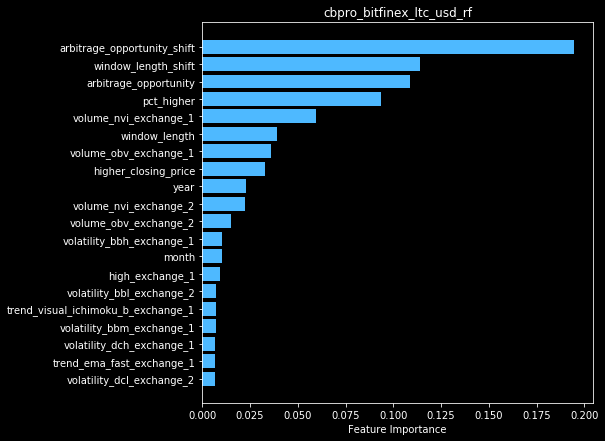

In [74]:
plot_feature_importances(['data/arb_data/cbpro_bitfinex_ltc_usd.csv'])

#### Discussion

#### Export

For hyperparameter tuning, we'll be using the top 100 features. We export them to a .txt file called `top_features.txt` for version control.

In [77]:
df = pd.read_csv('data/arb_data/cbpro_bitfinex_ltc_usd.csv', index_col=0)
columns = df.drop(labels=['target', 'closing_time'], axis=1).columns.to_list()

top_model = glob.glob('models/cbpro_bitfinex_ltc_usd_rf.pkl')

with open(top_model[0], 'rb') as f:
    model = pickle.load(f)
    
imp = pd.DataFrame(model.feature_importances_, columns).reset_index()
imp = imp.rename(columns={'index': 'features', 0: 'importance'})
imp = imp.sort_values(by='importance', ascending=False)[:100]
top_features = imp['features'].to_list()

# pickle dump top feature txt file
with open('data/top_features.txt', 'wb') as fp:
    pickle.dump(top_features, fp)

## Hyperparameter Tuning

In [84]:
# import features
with open ('data/top_features.txt', 'rb') as fp:
    top_features = pickle.load(fp)

create_models(
    train_data_paths=train_data_paths[:20], 
    model_type=RandomForestClassifier(
        n_jobs=-1, 
        random_state=42
    ), 
    features=top_features, 
    param_grid={'max_depth': [17, 19, 21, 25, 30, 40],
                'n_estimators': [100, 150],
                'max_features': ['auto', 50, 55, 60, 65, 70, 75]},
    filename = 'data/model_perf_hyper.csv'
)

2 iterable params
2 iterable params
2 iterable params


 --------------------------------------------------------------------------------------------------------------------- 

 Model 1/20: kraken_bitfinex_bch_btc 
 ---------------------------------------------------------------------------------------------------------------------
             train and test shape:  (4133, 141) (1791, 141)
             ----------------------------------------------------------------- 
              Model 1/84 
              params={'max_depth': 17, 'max_features': 'auto', 'n_estimators': 100} 
              -----------------------------------------------------------------
             percent profit mean: nan
             percent profit median: nan 


          Predicted 0
Actual 0         1791 

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1791

    accuracy                         1.0000      1791
   macro avg     1.0000    1.0000    1.0000 

## Model Performance

When baseline models are trained and hyperparameter tuning is done, we'll have a csv file in our data folder that looks like this. This is the data that will be analyzed in the evaluation notebook to choose the best models.

In [19]:
# # UNCOMMENT TO CONCATENATE MODEL PERFORMANCE CSVS

# # since we trained our models across several notebooks which 
# # isn't displayed here, we need to concatenate the csv data

# # first moved all the individual performance csvs into a new
# # directory called data/perf_data/

# # this will export 1 csv of all of the performance data
# # as data/perf_data.csv

# def concat_perf_csv(perf_csv_paths):
#     perf_df = pd.DataFrame()
#     for path in perf_csv_paths:
#         df = pd.read_csv(path)
#         perf_df = pd.concat([perf_df, df])
    
#     perf_df.to_csv('data/model_perf.csv', index=False)
#     return perf_df

# perf_csv_paths = glob.glob('data/perf_data/model_perf*.csv')
# concat_perf_csv(perf_csv_paths)

In [119]:
perf_df = pd.read_csv('data/model_perf.csv')
print(perf_df.shape) # (1290, 20)
perf_df.head()

(1290, 20)


,model_id,csv_name,model_label,params,accuracy,pct_profit_mean,pct_profit_median,FPR,correct_arb_neg1,correct_arb_1,correct_arb,precision_neg1,precision_0,precision_1,recall_neg1,recall_0,recall_1,f1_neg1,f1_0,f1_1
0,cbpro_gemini_bch_btc_rf_hyper_auto_17_100,cbpro_gemini_bch_btc,rf_hyper,"{'max_depth': 17, 'max_features': 'auto', 'n_e...",0.979234,1.55,1.19,0.029314,228,437,665,1.0,0.970686,0.997717,0.919355,0.999314,0.947939,0.957983,0.984792,0.972191
1,cbpro_gemini_bch_btc_rf_hyper_auto_17_150,cbpro_gemini_bch_btc,rf_hyper,"{'max_depth': 17, 'max_features': 'auto', 'n_e...",0.978772,1.56,1.19,0.030585,223,440,663,1.0,0.969415,1.000000,0.899194,1.000000,0.954447,0.946921,0.984470,0.976693
2,cbpro_gemini_bch_btc_rf_hyper_50_17_100,cbpro_gemini_bch_btc,rf_hyper,"{'max_depth': 17, 'max_features': 50, 'n_estim...",0.998616,1.50,1.14,0.002053,248,458,706,1.0,0.997947,1.000000,1.000000,1.000000,0.993492,1.000000,0.998972,0.996736
3,cbpro_gemini_bch_btc_rf_hyper_50_17_150,cbpro_gemini_bch_btc,rf_hyper,"{'max_depth': 17, 'max_features': 50, 'n_estim...",0.998616,1.50,1.14,0.002053,248,458,706,1.0,0.997947,1.000000,1.000000,1.000000,0.993492,1.000000,0.998972,0.996736
4,cbpro_gemini_bch_btc_rf_hyper_55_17_100,cbpro_gemini_bch_btc,rf_hyper,"{'max_depth': 17, 'max_features': 55, 'n_estim...",0.999077,1.50,1.13,0.001370,248,459,707,1.0,0.998630,1.000000,1.000000,1.000000,0.995662,1.000000,0.999315,0.997826


## Limitations
The data sets for all models were split by a 70/30 train/test split, meaning that the size of the test data varies greatly for each model. The size of the test set is larger or smaller depending on the starting size of the merged dataset for the two exchanges. The % profit mean is the average percentage gained if one were to act on all arbitrage opportunities predicted by that specific model during the period of the test set. With a larger test set, there is a better chance of seeing more arbitrage predictions, and the % profit mean number will be more accurate as it's averaged over more observations. Right now, it's possible that the % profit mean is skewed due to different testing timeframes where more or less arbitrage predictions are observed.
When more data is available, it may be more accurate to apply evaluation metrics to the last 100-200 arbitrage predictions by the model so that you can make valid comparisons between models.

## Next Steps For Modeling
work in progress
- More hyperparameter tuning
- Neural Networks
- Implement auto model retraining
- create a trigger that checks for model decay
- retrain models in cloud if decayed, select best performers, save new version to S3 Buckets
- save train/test data of newest version for reference
- Create a bot that will act on arbitrage predictions from models
- We haven't tried normalizing the dataset to see if it will improve accuracy, but that should be a top priority to anyone continuing this project

## Continued...
Model selection, evaluation, and visualization of performance will be carried out in the following notebook:
- [View on Github](https://github.com/Cryptolytic-app/cryptolyticapp/blob/master/modeling/3_arbitrage_model_evaluation.ipynb)

- [Jump to local copy](3_arbitrage_model_evaluation.ipynb)